# Introduction to NumPy

This chapter, along with chapter 3, outlines techniques for effectively loading, storing, and manipulating in-memory data in Python.
The topic is very broad: datasets can come from a wide range of sources and a wide range of formats, including be collections of documents, collections of images, collections of sound clips, collections of numerical measurements, or nearly anything else.
Despite this apparent heterogeneity, it will help us to think of all data fundamentally as arrays of numbers.

For example, images–particularly digital images–can be thought of as simply two-dimensional arrays of numbers representing pixel brightness across the area.
Sound clips can be thought of as one-dimensional arrays of intensity versus time.
Text can be converted in various ways into numerical representations, perhaps binary digits representing the frequency of certain words or pairs of words.
No matter what the data are, the first step in making it analyzable will be to transform them into arrays of numbers.
(We will discuss some specific examples of this process later in [Feature Engineering](05.04-Feature-Engineering.ipynb))

For this reason, efficient storage and manipulation of numerical arrays is absolutely fundamental to the process of doing data science.
We'll now take a look at the specialized tools that Python has for handling such numerical arrays: the NumPy package, and the Pandas package (discussed in Chapter 3).

This chapter will cover NumPy in detail. NumPy (short for *Numerical Python*) provides an efficient interface to store and operate on dense data buffers.
In some ways, NumPy arrays are like Python's built-in ``list`` type, but NumPy arrays provide much more efficient storage and data operations as the arrays grow larger in size.
NumPy arrays form the core of nearly the entire ecosystem of data science tools in Python, so time spent learning to use NumPy effectively will be valuable no matter what aspect of data science interests you.

If you followed the advice outlined in the Preface and installed the Anaconda stack, you already have NumPy installed and ready to go.
If you're more the do-it-yourself type, you can go to http://www.numpy.org/ and follow the installation instructions found there.
Once you do, you can import NumPy and double-check the version:

In [ ]:
import numpy
numpy.__version__

'1.21.6'

For the pieces of the package discussed here, I'd recommend NumPy version 1.8 or later.
By convention, you'll find that most people in the SciPy/PyData world will import NumPy using ``np`` as an alias:

In [ ]:
import numpy as np

Throughout this chapter, and indeed the rest of the book, you'll find that this is the way we will import and use NumPy.

## Reminder about Built In Documentation

As you read through this chapter, don't forget that IPython gives you the ability to quickly explore the contents of a package (by using the tab-completion feature), as well as the documentation of various functions (using the ``?`` character – Refer back to [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb)).

For example, to display all the contents of the numpy namespace, you can type this:

```ipython
In [3]: np.<TAB>
```

And to display NumPy's built-in documentation, you can use this:

```ipython
In [4]: np?
```

More detailed documentation, along with tutorials and other resources, can be found at http://www.numpy.org.

In [ ]:
np?

# Understanding Data Types in Python

Effective data-driven science and computation requires understanding how data is stored and manipulated.
This section outlines and contrasts how arrays of data are handled in the Python language itself, and how NumPy improves on this.
Understanding this difference is fundamental to understanding much of the material throughout the rest of the book.

Users of Python are often drawn-in by its ease of use, one piece of which is dynamic typing.
While a statically-typed language like C or Java requires each variable to be explicitly declared, a dynamically-typed language like Python skips this specification. For example, in C you might specify a particular operation as follows:

```C
/* C code */
int result = 0;
for(int i=0; i<100; i++){
    result += i;
}
```

While in Python the equivalent operation could be written this way:

```python
# Python code
result = 0
for i in range(100):
    result += i
```

Notice the main difference: in C, the data types of each variable are explicitly declared, while in Python the types are dynamically inferred. This means, for example, that we can assign any kind of data to any variable:

```python
# Python code
x = 4
x = "four"
```

Here we've switched the contents of ``x`` from an integer to a string. The same thing in C would lead (depending on compiler settings) to a compilation error or other unintented consequences:

```C
/* C code */
int x = 4;
x = "four";  // FAILS
```

This sort of flexibility is one piece that makes Python and other dynamically-typed languages convenient and easy to use.
Understanding *how* this works is an important piece of learning to analyze data efficiently and effectively with Python.
But what this type-flexibility also points to is the fact that Python variables are more than just their value; they also contain extra information about the type of the value. We'll explore this more in the sections that follow.

## A Python Integer Is More Than Just an Integer

The standard Python implementation is written in C.
This means that every Python object is simply a cleverly-disguised C structure, which contains not only its value, but other information as well. For example, when we define an integer in Python, such as ``x = 10000``, ``x`` is not just a "raw" integer. It's actually a pointer to a compound C structure, which contains several values.
Looking through the Python 3.4 source code, we find that the integer (long) type definition effectively looks like this (once the C macros are expanded):

```C
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};
```

A single integer in Python 3.4 actually contains four pieces:

- ``ob_refcnt``, a reference count that helps Python silently handle memory allocation and deallocation
- ``ob_type``, which encodes the type of the variable
- ``ob_size``, which specifies the size of the following data members
- ``ob_digit``, which contains the actual integer value that we expect the Python variable to represent.

This means that there is some overhead in storing an integer in Python as compared to an integer in a compiled language like C, as illustrated in the following figure:

![Integer Memory Layout](figures/cint_vs_pyint.png)

Here ``PyObject_HEAD`` is the part of the structure containing the reference count, type code, and other pieces mentioned before.

Notice the difference here: a C integer is essentially a label for a position in memory whose bytes encode an integer value.
A Python integer is a pointer to a position in memory containing all the Python object information, including the bytes that contain the integer value.
This extra information in the Python integer structure is what allows Python to be coded so freely and dynamically.
All this additional information in Python types comes at a cost, however, which becomes especially apparent in structures that combine many of these objects.

## A Python List Is More Than Just a List

Let's consider now what happens when we use a Python data structure that holds many Python objects.
The standard mutable multi-element container in Python is the list.
We can create a list of integers as follows:

In [ ]:
L = list(range(10))
L

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
type(L[0])

int

Or, similarly, a list of strings:

In [ ]:
L2 = [str(c) for c in L]
L2

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
type(L2[0])

str

Because of Python's dynamic typing, we can even create heterogeneous lists:

In [ ]:
L3 = [True, "2", 3.0, 4]
[type(item) for item in L3]

[bool, str, float, int]

But this flexibility comes at a cost: to allow these flexible types, each item in the list must contain its own type info, reference count, and other information–that is, each item is a complete Python object.
In the special case that all variables are of the same type, much of this information is redundant: it can be much more efficient to store data in a fixed-type array.
The difference between a dynamic-type list and a fixed-type (NumPy-style) array is illustrated in the following figure:

![Array Memory Layout](figures/array_vs_list.png)

At the implementation level, the array essentially contains a single pointer to one contiguous block of data.
The Python list, on the other hand, contains a pointer to a block of pointers, each of which in turn points to a full Python object like the Python integer we saw earlier.
Again, the advantage of the list is flexibility: because each list element is a full structure containing both data and type information, the list can be filled with data of any desired type.
Fixed-type NumPy-style arrays lack this flexibility, but are much more efficient for storing and manipulating data.

## Fixed-Type Arrays in Python

Python offers several different options for storing data in efficient, fixed-type data buffers.
The built-in ``array`` module (available since Python 3.3) can be used to create dense arrays of a uniform type:

In [ ]:
import array
L = list(range(10))
A = array.array('i', L)
A

array('i', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Here ``'i'`` is a type code indicating the contents are integers.

Much more useful, however, is the ``ndarray`` object of the NumPy package.
While Python's ``array`` object provides efficient storage of array-based data, NumPy adds to this efficient *operations* on that data.
We will explore these operations in later sections; here we'll demonstrate several ways of creating a NumPy array.

We'll start with the standard NumPy import, under the alias ``np``:

In [ ]:
import numpy as np

## Creating Arrays from Python Lists

First, we can use ``np.array`` to create arrays from Python lists:

In [ ]:
# integer array:
np.array([1, 4, 2, 5, 3])

array([1, 4, 2, 5, 3])

Remember that unlike Python lists, NumPy is constrained to arrays that all contain the same type.
If types do not match, NumPy will upcast if possible (here, integers are up-cast to floating point):

In [ ]:
np.array([3.14, 4, 2, 3])

array([3.14, 4.  , 2.  , 3.  ])

If we want to explicitly set the data type of the resulting array, we can use the ``dtype`` keyword:

In [ ]:
np.array([1, 2, 3, 4], dtype='int16')

array([1, 2, 3, 4], dtype=int16)

Finally, unlike Python lists, NumPy arrays can explicitly be multi-dimensional; here's one way of initializing a multidimensional array using a list of lists:

In [ ]:
# nested lists result in multi-dimensional arrays
np.array([range(i, i + 3) for i in [2, 4, 6]])

array([[2, 3, 4],
       [4, 5, 6],
       [6, 7, 8]])

The inner lists are treated as rows of the resulting two-dimensional array.

## Creating Arrays from Scratch

Especially for larger arrays, it is more efficient to create arrays from scratch using routines built into NumPy.
Here are several examples:

In [ ]:
# Create a length-10 integer array filled with zeros
np.zeros((3,5), dtype=int)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
# Create a 3x5 floating-point array filled with ones
np.ones((3, 5), dtype=float)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [ ]:
# Create a 3x5 array filled with 3.14
np.full((3, 5), 3.14)

array([[3.14, 3.14, 3.14, 3.14, 3.14],
       [3.14, 3.14, 3.14, 3.14, 3.14],
       [3.14, 3.14, 3.14, 3.14, 3.14]])

In [ ]:
# Create an array filled with a linear sequence
# Starting at 0, ending at 20, stepping by 2
# (this is similar to the built-in range() function)
np.arange(0, 20, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [ ]:
# Create an array of five values evenly spaced between 0 and 1
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
# Create a 3x3 array of uniformly distributed
# random values between 0 and 1
np.random.random((3, 3))

array([[0.72801504, 0.80310501, 0.78709527],
       [0.14812371, 0.3755372 , 0.82547891],
       [0.45404682, 0.72208692, 0.54811118]])

In [ ]:
# Create a 3x3 array of normally distributed random values
# with mean 0 and standard deviation 1
np.random.normal(50, 7, (3, 3))

array([[49.18713667, 30.69095337, 55.22967806],
       [44.35656173, 53.56263105, 50.85504308],
       [54.55428039, 51.65497688, 65.9768582 ]])

In [ ]:
# Create a 3x3 array of random integers in the interval [0, 10)
np.random.randint(0, 10, (3, 3))

array([[7, 6, 5],
       [9, 7, 2],
       [0, 3, 4]])

In [ ]:
# Create a 3x3 identity matrix
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# Create an uninitialized array of three integers
# The values will be whatever happens to already exist at that memory location
np.empty(3)

array([1., 1., 1.])

## NumPy Standard Data Types

NumPy arrays contain values of a single type, so it is important to have detailed knowledge of those types and their limitations.
Because NumPy is built in C, the types will be familiar to users of C, Fortran, and other related languages.

The standard NumPy data types are listed in the following table.
Note that when constructing an array, they can be specified using a string:

```python
np.zeros(10, dtype='int16')
```

Or using the associated NumPy object:

```python
np.zeros(10, dtype=np.int16)
```

| Data type	    | Description |
|---------------|-------------|
| ``bool_``     | Boolean (True or False) stored as a byte |
| ``int_``      | Default integer type (same as C ``long``; normally either ``int64`` or ``int32``)| 
| ``intc``      | Identical to C ``int`` (normally ``int32`` or ``int64``)| 
| ``intp``      | Integer used for indexing (same as C ``ssize_t``; normally either ``int32`` or ``int64``)| 
| ``int8``      | Byte (-128 to 127)| 
| ``int16``     | Integer (-32768 to 32767)|
| ``int32``     | Integer (-2147483648 to 2147483647)|
| ``int64``     | Integer (-9223372036854775808 to 9223372036854775807)| 
| ``uint8``     | Unsigned integer (0 to 255)| 
| ``uint16``    | Unsigned integer (0 to 65535)| 
| ``uint32``    | Unsigned integer (0 to 4294967295)| 
| ``uint64``    | Unsigned integer (0 to 18446744073709551615)| 
| ``float_``    | Shorthand for ``float64``.| 
| ``float16``   | Half precision float: sign bit, 5 bits exponent, 10 bits mantissa| 
| ``float32``   | Single precision float: sign bit, 8 bits exponent, 23 bits mantissa| 
| ``float64``   | Double precision float: sign bit, 11 bits exponent, 52 bits mantissa| 
| ``complex_``  | Shorthand for ``complex128``.| 
| ``complex64`` | Complex number, represented by two 32-bit floats| 
| ``complex128``| Complex number, represented by two 64-bit floats| 

More advanced type specification is possible, such as specifying big or little endian numbers; for more information, refer to the [NumPy documentation](http://numpy.org/).
NumPy also supports compound data types, which will be covered in [Structured Data: NumPy's Structured Arrays](02.09-Structured-Data-NumPy.ipynb).

# The Basics of NumPy Arrays

Data manipulation in Python is nearly synonymous with NumPy array manipulation: even newer tools like Pandas ([Chapter 3](03.00-Introduction-to-Pandas.ipynb)) are built around the NumPy array.
This section will present several examples of using NumPy array manipulation to access data and subarrays, and to split, reshape, and join the arrays.
While the types of operations shown here may seem a bit dry and pedantic, they comprise the building blocks of many other examples used throughout the book.
Get to know them well!

We'll cover a few categories of basic array manipulations here:

- *Attributes of arrays*: Determining the size, shape, memory consumption, and data types of arrays
- *Indexing of arrays*: Getting and setting the value of individual array elements
- *Slicing of arrays*: Getting and setting smaller subarrays within a larger array
- *Reshaping of arrays*: Changing the shape of a given array
- *Joining and splitting of arrays*: Combining multiple arrays into one, and splitting one array into many

## NumPy Array Attributes

First let's discuss some useful array attributes.
We'll start by defining three random arrays, a one-dimensional, two-dimensional, and three-dimensional array.
We'll use NumPy's random number generator, which we will *seed* with a set value in order to ensure that the same random arrays are generated each time this code is run:

In [ ]:
import numpy as np
np.random.seed(0)  # seed for reproducibility

x1 = np.random.randint(10, size=6)  # One-dimensional array
x2 = np.random.randint(10, size=(3, 4))  # Two-dimensional array
x3 = np.random.randint(10, size=(3, 4, 5))  # Three-dimensional array

In [ ]:
x1

array([5, 0, 3, 3, 7, 9])

Each array has attributes ``ndim`` (the number of dimensions), ``shape`` (the size of each dimension), and ``size`` (the total size of the array):

In [ ]:
print("x3 ndim: ", x3.ndim)
print("x3 shape:", x3.shape)
print("x3 size: ", x3.size)

x3 ndim:  3
x3 shape: (3, 4, 5)
x3 size:  60


Another useful attribute is the ``dtype``, the data type of the array (which we discussed previously in [Understanding Data Types in Python](02.01-Understanding-Data-Types.ipynb)):

In [ ]:
print("dtype:", x3.dtype)

dtype: int64


Other attributes include ``itemsize``, which lists the size (in bytes) of each array element, and ``nbytes``, which lists the total size (in bytes) of the array:

In [ ]:
print("itemsize:", x3.itemsize, "bytes")
print("nbytes:", x3.nbytes, "bytes")

itemsize: 8 bytes
nbytes: 480 bytes


In general, we expect that ``nbytes`` is equal to ``itemsize`` times ``size``.

## Array Indexing: Accessing Single Elements

If you are familiar with Python's standard list indexing, indexing in NumPy will feel quite familiar.
In a one-dimensional array, the $i^{th}$ value (counting from zero) can be accessed by specifying the desired index in square brackets, just as with Python lists:

In [ ]:
x1

array([5, 0, 3, 3, 7, 9])

In [ ]:
x1[0]

5

In [ ]:
x1[4]

7

To index from the end of the array, you can use negative indices:

In [ ]:
x1[-1]

9

In [ ]:
x1[-2]

7

In a multi-dimensional array, items can be accessed using a comma-separated tuple of indices:

In [ ]:
x2

array([[3, 5, 2, 4],
       [7, 6, 8, 8],
       [1, 6, 7, 7]])

In [ ]:
x2[0, 0]

3

In [ ]:
x2[2, 0]

1

In [ ]:
x2[2, -1]

7

Values can also be modified using any of the above index notation:

In [ ]:
x2[0, 0] = 12
x2

array([[12,  5,  2,  4],
       [ 7,  6,  8,  8],
       [ 1,  6,  7,  7]])

Keep in mind that, unlike Python lists, NumPy arrays have a fixed type.
This means, for example, that if you attempt to insert a floating-point value to an integer array, the value will be silently truncated. Don't be caught unaware by this behavior!

In [ ]:
x1[0] = 3.14159  # this will be truncated!
x1

array([3.14159e+000, 0.00000e+000, 1.48220e-323, 1.48220e-323,
       3.45846e-323, 4.44659e-323])

In [ ]:
x1.dtype='float64'

In [ ]:
x1

array([1.5e-323, 0.0e+000, 1.5e-323, 1.5e-323, 3.5e-323, 4.4e-323])

In [ ]:
x1[0] = 3.14159  # this will be truncated!
x1

array([3.14159e+000, 0.00000e+000, 1.48220e-323, 1.48220e-323,
       3.45846e-323, 4.44659e-323])

## Array Slicing: Accessing Subarrays

Just as we can use square brackets to access individual array elements, we can also use them to access subarrays with the *slice* notation, marked by the colon (``:``) character.
The NumPy slicing syntax follows that of the standard Python list; to access a slice of an array ``x``, use this:
``` python
x[start:stop:step]
```
If any of these are unspecified, they default to the values ``start=0``, ``stop=``*``size of dimension``*, ``step=1``.
We'll take a look at accessing sub-arrays in one dimension and in multiple dimensions.

### One-dimensional subarrays

In [ ]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
x[:5]  # first five elements

array([0, 1, 2, 3, 4])

In [ ]:
x[5:]  # elements after index 5

array([5, 6, 7, 8, 9])

In [ ]:
x[4:7]  # middle sub-array

array([4, 5, 6])

In [ ]:
x[::2]  # every other element

array([0, 2, 4, 6, 8])

In [ ]:
x[1::2]  # every other element, starting at index 1

array([1, 3, 5, 7, 9])

A potentially confusing case is when the ``step`` value is negative.
In this case, the defaults for ``start`` and ``stop`` are swapped.
This becomes a convenient way to reverse an array:

In [ ]:
x[::-1]  # all elements, reversed

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [ ]:
x[5::-2]  # reversed every other from index 5

array([5, 3, 1])

### Multi-dimensional subarrays

Multi-dimensional slices work in the same way, with multiple slices separated by commas.
For example:

In [ ]:
x2

array([[12,  5,  2,  4],
       [ 7,  6,  8,  8],
       [ 1,  6,  7,  7]])

In [ ]:
x2[:2, :3]  # two rows, three columns

array([[12,  5,  2],
       [ 7,  6,  8]])

In [ ]:
x2[:3, ::2]  # all rows, every other column

array([[12,  2],
       [ 7,  8],
       [ 1,  7]])

Finally, subarray dimensions can even be reversed together:

In [ ]:
x2[::-1, ::-1]

array([[ 7,  7,  6,  1],
       [ 8,  8,  6,  7],
       [ 4,  2,  5, 12]])

#### Accessing array rows and columns

One commonly needed routine is accessing of single rows or columns of an array.
This can be done by combining indexing and slicing, using an empty slice marked by a single colon (``:``):

In [ ]:
print(x2[:, 0])  # first column of x2

[12  7  1]


In [ ]:
print(x2[0, :])  # first row of x2

[12  5  2  4]


In the case of row access, the empty slice can be omitted for a more compact syntax:

In [ ]:
print(x2[0])  # equivalent to x2[0, :]

[12  5  2  4]


### Subarrays as no-copy views

One important–and extremely useful–thing to know about array slices is that they return *views* rather than *copies* of the array data.
This is one area in which NumPy array slicing differs from Python list slicing: in lists, slices will be copies.
Consider our two-dimensional array from before:

In [ ]:
print(x2)

[[12  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


Let's extract a $2 \times 2$ subarray from this:

In [ ]:
x2_sub = x2[:2, :2]
print(x2_sub)

[[12  5]
 [ 7  6]]


Now if we modify this subarray, we'll see that the original array is changed! Observe:

In [ ]:
x2_sub[0, 0] = 99
print(x2_sub)

[[99  5]
 [ 7  6]]


In [ ]:
print(x2)

[[99  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


This default behavior is actually quite useful: it means that when we work with large datasets, we can access and process pieces of these datasets without the need to copy the underlying data buffer.

### Creating copies of arrays

Despite the nice features of array views, it is sometimes useful to instead explicitly copy the data within an array or a subarray. This can be most easily done with the ``copy()`` method:

In [ ]:
x2_sub_copy = x2[:2, :2].copy()
print(x2_sub_copy)

[[99  5]
 [ 7  6]]


If we now modify this subarray, the original array is not touched:

In [ ]:
x2_sub_copy[0, 0] = 42
print(x2_sub_copy)

[[42  5]
 [ 7  6]]


In [ ]:
print(x2)

[[99  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


## Reshaping of Arrays

Another useful type of operation is reshaping of arrays.
The most flexible way of doing this is with the ``reshape`` method.
For example, if you want to put the numbers 1 through 9 in a $3 \times 3$ grid, you can do the following:

In [ ]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
grid = np.arange(1, 10).reshape((3, 3))
print(grid)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


Note that for this to work, the size of the initial array must match the size of the reshaped array. 
Where possible, the ``reshape`` method will use a no-copy view of the initial array, but with non-contiguous memory buffers this is not always the case.

Another common reshaping pattern is the conversion of a one-dimensional array into a two-dimensional row or column matrix.
This can be done with the ``reshape`` method, or more easily done by making use of the ``newaxis`` keyword within a slice operation:

In [ ]:
x = np.array([1, 2, 3])
print(x.shape)
# row vector via reshape
x.reshape((1, 3))
print(x.reshape((3, 1)).shape)

(3,)
(3, 1)


In [ ]:
# row vector via newaxis
x[np.newaxis, :]

array([[1, 2, 3]])

In [ ]:
# column vector via reshape
x.reshape((3, 1))

array([[1],
       [2],
       [3]])

In [ ]:
# column vector via newaxis
x[:, np.newaxis]

array([[1],
       [2],
       [3]])

We will see this type of transformation often throughout the remainder of the book.

## Array Concatenation and Splitting

All of the preceding routines worked on single arrays. It's also possible to combine multiple arrays into one, and to conversely split a single array into multiple arrays. We'll take a look at those operations here.

### Concatenation of arrays

Concatenation, or joining of two arrays in NumPy, is primarily accomplished using the routines ``np.concatenate``, ``np.vstack``, and ``np.hstack``.
``np.concatenate`` takes a tuple or list of arrays as its first argument, as we can see here:

In [ ]:
x = np.array([1, 2, 3])
y = np.array([3, 2, 1])
np.concatenate([x, y, y])

array([1, 2, 3, 3, 2, 1, 3, 2, 1])

You can also concatenate more than two arrays at once:

In [ ]:
z = [99, 99, 99]
print(np.concatenate([x, y, z]))

[ 1  2  3  3  2  1 99 99 99]


It can also be used for two-dimensional arrays:

In [ ]:
grid = np.array([[1, 2, 3],
                 [4, 5, 6]])
grid

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
# concatenate along the first axis
np.concatenate([grid, grid], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [ ]:
# concatenate along the second axis (zero-indexed)
np.concatenate([grid, grid], axis=1)

array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6]])

For working with arrays of mixed dimensions, it can be clearer to use the ``np.vstack`` (vertical stack) and ``np.hstack`` (horizontal stack) functions:

In [ ]:
x = np.array([1, 2, 3])
grid = np.array([[9, 8, 7],
                 [6, 5, 4]])

# vertically stack the arrays
np.vstack([x, grid])

array([[1, 2, 3],
       [9, 8, 7],
       [6, 5, 4]])

In [ ]:
# horizontally stack the arrays
y = np.array([[99],
              [99]])
np.hstack([grid, y])

array([[ 9,  8,  7, 99],
       [ 6,  5,  4, 99]])

Similary, ``np.dstack`` will stack arrays along the third axis.

### Splitting of arrays

The opposite of concatenation is splitting, which is implemented by the functions ``np.split``, ``np.hsplit``, and ``np.vsplit``.  For each of these, we can pass a list of indices giving the split points:

In [ ]:
x = [1, 2, 3, 99, 99, 3, 2, 1]
x1, x2, x3 = np.split(x, [3, 5])
print(x1, x2, x3)

[1 2 3] [99 99] [3 2 1]


Notice that *N* split-points, leads to *N + 1* subarrays.
The related functions ``np.hsplit`` and ``np.vsplit`` are similar:

In [ ]:
grid = np.arange(16).reshape((4, 4))
grid

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [ ]:
upper, lower = np.vsplit(grid, [2])
print(upper)
print(lower)

[[0 1 2 3]
 [4 5 6 7]]
[[ 8  9 10 11]
 [12 13 14 15]]


In [ ]:
left, right = np.hsplit(grid, [2])
print(left)
print(right)

[[ 0  1]
 [ 4  5]
 [ 8  9]
 [12 13]]
[[ 2  3]
 [ 6  7]
 [10 11]
 [14 15]]


Similarly, ``np.dsplit`` will split arrays along the third axis.

# Computation on NumPy Arrays: Universal Functions

Up until now, we have been discussing some of the basic nuts and bolts of NumPy; in the next few sections, we will dive into the reasons that NumPy is so important in the Python data science world.
Namely, it provides an easy and flexible interface to optimized computation with arrays of data.

Computation on NumPy arrays can be very fast, or it can be very slow.
The key to making it fast is to use *vectorized* operations, generally implemented through NumPy's *universal functions* (ufuncs).
This section motivates the need for NumPy's ufuncs, which can be used to make repeated calculations on array elements much more efficient.
It then introduces many of the most common and useful arithmetic ufuncs available in the NumPy package.

## The Slowness of Loops

Python's default implementation (known as CPython) does some operations very slowly.
This is in part due to the dynamic, interpreted nature of the language: the fact that types are flexible, so that sequences of operations cannot be compiled down to efficient machine code as in languages like C and Fortran.
Recently there have been various attempts to address this weakness: well-known examples are the [PyPy](http://pypy.org/) project, a just-in-time compiled implementation of Python; the [Cython](http://cython.org) project, which converts Python code to compilable C code; and the [Numba](http://numba.pydata.org/) project, which converts snippets of Python code to fast LLVM bytecode.
Each of these has its strengths and weaknesses, but it is safe to say that none of the three approaches has yet surpassed the reach and popularity of the standard CPython engine.

The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated – for instance looping over arrays to operate on each element.
For example, imagine we have an array of values and we'd like to compute the reciprocal of each.
A straightforward approach might look like this:

In [ ]:
import numpy as np
np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([0.16666667, 1.        , 0.25      , 0.25      , 0.125     ])

This implementation probably feels fairly natural to someone from, say, a C or Java background.
But if we measure the execution time of this code for a large input, we see that this operation is very slow, perhaps surprisingly so!
We'll benchmark this with IPython's ``%timeit`` magic (discussed in [Profiling and Timing Code](01.07-Timing-and-Profiling.ipynb)):

In [ ]:
big_array = np.random.randint(1, 100, size=1000000)
%timeit compute_reciprocals(big_array)

2.29 s ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes several seconds to compute these million operations and to store the result!
When even cell phones have processing speeds measured in Giga-FLOPS (i.e., billions of numerical operations per second), this seems almost absurdly slow.
It turns out that the bottleneck here is not the operations themselves, but the type-checking and function dispatches that CPython must do at each cycle of the loop.
Each time the reciprocal is computed, Python first examines the object's type and does a dynamic lookup of the correct function to use for that type.
If we were working in compiled code instead, this type specification would be known before the code executes and the result could be computed much more efficiently.

## Introducing UFuncs

For many types of operations, NumPy provides a convenient interface into just this kind of statically typed, compiled routine. This is known as a *vectorized* operation.
This can be accomplished by simply performing an operation on the array, which will then be applied to each element.
This vectorized approach is designed to push the loop into the compiled layer that underlies NumPy, leading to much faster execution.

Compare the results of the following two:

In [ ]:
print(compute_reciprocals(values))
print(1.0 / values)

[0.16666667 1.         0.25       0.25       0.125     ]
[0.16666667 1.         0.25       0.25       0.125     ]


Looking at the execution time for our big array, we see that it completes orders of magnitude faster than the Python loop:

In [ ]:
%timeit (1.0 / big_array)

2.9 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Vectorized operations in NumPy are implemented via *ufuncs*, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.
Ufuncs are extremely flexible – before we saw an operation between a scalar and an array, but we can also operate between two arrays:

In [ ]:
np.arange(5) / np.arange(1, 6)

array([0.        , 0.5       , 0.66666667, 0.75      , 0.8       ])

And ufunc operations are not limited to one-dimensional arrays–they can also act on multi-dimensional arrays as well:

In [ ]:
x = np.arange(9).reshape((3, 3))
2 ** x

array([[  1,   2,   4],
       [  8,  16,  32],
       [ 64, 128, 256]])

Computations using vectorization through ufuncs are nearly always more efficient than their counterpart implemented using Python loops, especially as the arrays grow in size.
Any time you see such a loop in a Python script, you should consider whether it can be replaced with a vectorized expression.

## Exploring NumPy's UFuncs

Ufuncs exist in two flavors: *unary ufuncs*, which operate on a single input, and *binary ufuncs*, which operate on two inputs.
We'll see examples of both these types of functions here.

### Array arithmetic

NumPy's ufuncs feel very natural to use because they make use of Python's native arithmetic operators.
The standard addition, subtraction, multiplication, and division can all be used:

In [ ]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # floor division

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


There is also a unary ufunc for negation, and a ``**`` operator for exponentiation, and a ``%`` operator for modulus:

In [ ]:
print("-x     = ", -x)
print("x ** 2 = ", x ** 2)
print("x % 2  = ", x % 2)

-x     =  [ 0 -1 -2 -3]
x ** 2 =  [0 1 4 9]
x % 2  =  [0 1 0 1]


In addition, these can be strung together however you wish, and the standard order of operations is respected:

In [ ]:
-(0.5*x + 1) ** 2

array([-1.  , -2.25, -4.  , -6.25])

Each of these arithmetic operations are simply convenient wrappers around specific functions built into NumPy; for example, the ``+`` operator is a wrapper for the ``add`` function:

In [ ]:
np.add(x, 2)

array([2, 3, 4, 5])

The following table lists the arithmetic operators implemented in NumPy:

| Operator	    | Equivalent ufunc    | Description                           |
|---------------|---------------------|---------------------------------------|
|``+``          |``np.add``           |Addition (e.g., ``1 + 1 = 2``)         |
|``-``          |``np.subtract``      |Subtraction (e.g., ``3 - 2 = 1``)      |
|``-``          |``np.negative``      |Unary negation (e.g., ``-2``)          |
|``*``          |``np.multiply``      |Multiplication (e.g., ``2 * 3 = 6``)   |
|``/``          |``np.divide``        |Division (e.g., ``3 / 2 = 1.5``)       |
|``//``         |``np.floor_divide``  |Floor division (e.g., ``3 // 2 = 1``)  |
|``**``         |``np.power``         |Exponentiation (e.g., ``2 ** 3 = 8``)  |
|``%``          |``np.mod``           |Modulus/remainder (e.g., ``9 % 4 = 1``)|

Additionally there are Boolean/bitwise operators; we will explore these in [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb).

### Absolute value

Just as NumPy understands Python's built-in arithmetic operators, it also understands Python's built-in absolute value function:

In [ ]:
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

The corresponding NumPy ufunc is ``np.absolute``, which is also available under the alias ``np.abs``:

In [ ]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [ ]:
np.abs(x)

array([2, 1, 0, 1, 2])

This ufunc can also handle complex data, in which the absolute value returns the magnitude:

In [ ]:
x = np.array([3 - 4j, 4 - 3j, 2 + 0j, 0 + 1j])
np.abs(x)

array([5., 5., 2., 1.])

### Trigonometric functions

NumPy provides a large number of useful ufuncs, and some of the most useful for the data scientist are the trigonometric functions.
We'll start by defining an array of angles:

In [ ]:
theta = np.linspace(0, np.pi, 3)

Now we can compute some trigonometric functions on these values:

In [ ]:
print("theta      = ", theta)
print("sin(theta) = ", np.sin(theta))
print("cos(theta) = ", np.cos(theta))
print("tan(theta) = ", np.tan(theta))

theta      =  [0.         1.57079633 3.14159265]
sin(theta) =  [0.0000000e+00 1.0000000e+00 1.2246468e-16]
cos(theta) =  [ 1.000000e+00  6.123234e-17 -1.000000e+00]
tan(theta) =  [ 0.00000000e+00  1.63312394e+16 -1.22464680e-16]


The values are computed to within machine precision, which is why values that should be zero do not always hit exactly zero.
Inverse trigonometric functions are also available:

In [ ]:
x = [-1, 0, 1]
print("x         = ", x)
print("arcsin(x) = ", np.arcsin(x))
print("arccos(x) = ", np.arccos(x))
print("arctan(x) = ", np.arctan(x))

x         =  [-1, 0, 1]
arcsin(x) =  [-1.57079633  0.          1.57079633]
arccos(x) =  [3.14159265 1.57079633 0.        ]
arctan(x) =  [-0.78539816  0.          0.78539816]


### Exponents and logarithms

Another common type of operation available in a NumPy ufunc are the exponentials:

In [ ]:
x = [1, 2, 3]
print("x     =", x)
print("e^x   =", np.exp(x))
print("2^x   =", np.exp2(x))
print("3^x   =", np.power(3, x))

x     = [1, 2, 3]
e^x   = [ 2.71828183  7.3890561  20.08553692]
2^x   = [2. 4. 8.]
3^x   = [ 3  9 27]


The inverse of the exponentials, the logarithms, are also available.
The basic ``np.log`` gives the natural logarithm; if you prefer to compute the base-2 logarithm or the base-10 logarithm, these are available as well:

In [ ]:
x = [1, 2, 4, 10]
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x        = [1, 2, 4, 10]
ln(x)    = [0.         0.69314718 1.38629436 2.30258509]
log2(x)  = [0.         1.         2.         3.32192809]
log10(x) = [0.         0.30103    0.60205999 1.        ]


There are also some specialized versions that are useful for maintaining precision with very small input:

In [ ]:
x = [0, 0.001, 0.01, 0.1]
print("exp(x) - 1 =", np.expm1(x))
print("log(1 + x) =", np.log1p(x))

exp(x) - 1 = [0.         0.0010005  0.01005017 0.10517092]
log(1 + x) = [0.         0.0009995  0.00995033 0.09531018]


When ``x`` is very small, these functions give more precise values than if the raw ``np.log`` or ``np.exp`` were to be used.

### Specialized ufuncs

NumPy has many more ufuncs available, including hyperbolic trig functions, bitwise arithmetic, comparison operators, conversions from radians to degrees, rounding and remainders, and much more.
A look through the NumPy documentation reveals a lot of interesting functionality.

Another excellent source for more specialized and obscure ufuncs is the submodule ``scipy.special``.
If you want to compute some obscure mathematical function on your data, chances are it is implemented in ``scipy.special``.
There are far too many functions to list them all, but the following snippet shows a couple that might come up in a statistics context:

In [ ]:
from scipy import special

In [ ]:
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [1.0000e+00 2.4000e+01 3.6288e+05]
ln|gamma(x)| = [ 0.          3.17805383 12.80182748]
beta(x, 2)   = [0.5        0.03333333 0.00909091]


In [ ]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x))
print("erfc(x) =", special.erfc(x))
print("erfinv(x) =", special.erfinv(x))

erf(x)  = [0.         0.32862676 0.67780119 0.84270079]
erfc(x) = [1.         0.67137324 0.32219881 0.15729921]
erfinv(x) = [0.         0.27246271 0.73286908        inf]


There are many, many more ufuncs available in both NumPy and ``scipy.special``.
Because the documentation of these packages is available online, a web search along the lines of "gamma function python" will generally find the relevant information.

## Advanced Ufunc Features

Many NumPy users make use of ufuncs without ever learning their full set of features.
We'll outline a few specialized features of ufuncs here.

### Specifying output

For large calculations, it is sometimes useful to be able to specify the array where the result of the calculation will be stored.
Rather than creating a temporary array, this can be used to write computation results directly to the memory location where you'd like them to be.
For all ufuncs, this can be done using the ``out`` argument of the function:

In [ ]:
x = np.arange(5)
y = np.empty(5)
np.multiply(x, 10, out=y)
print(y)

[ 0. 10. 20. 30. 40.]


This can even be used with array views. For example, we can write the results of a computation to every other element of a specified array:

In [ ]:
y = np.zeros(10)
np.power(2, x, out=y[::2])
print(y)

[ 1.  0.  2.  0.  4.  0.  8.  0. 16.  0.]


If we had instead written ``y[::2] = 2 ** x``, this would have resulted in the creation of a temporary array to hold the results of ``2 ** x``, followed by a second operation copying those values into the ``y`` array.
This doesn't make much of a difference for such a small computation, but for very large arrays the memory savings from careful use of the ``out`` argument can be significant.

### Aggregates

For binary ufuncs, there are some interesting aggregates that can be computed directly from the object.
For example, if we'd like to *reduce* an array with a particular operation, we can use the ``reduce`` method of any ufunc.
A reduce repeatedly applies a given operation to the elements of an array until only a single result remains.

For example, calling ``reduce`` on the ``add`` ufunc returns the sum of all elements in the array:

In [ ]:
x = np.arange(1, 6)
np.add.reduce(x)

15

Similarly, calling ``reduce`` on the ``multiply`` ufunc results in the product of all array elements:

In [ ]:
np.multiply.reduce(x)

120

If we'd like to store all the intermediate results of the computation, we can instead use ``accumulate``:

In [ ]:
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15])

In [ ]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

Note that for these particular cases, there are dedicated NumPy functions to compute the results (``np.sum``, ``np.prod``, ``np.cumsum``, ``np.cumprod``), which we'll explore in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb).

### Outer products

Finally, any ufunc can compute the output of all pairs of two different inputs using the ``outer`` method.
This allows you, in one line, to do things like create a multiplication table:

In [ ]:
x = np.arange(1, 6)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

The ``ufunc.at`` and ``ufunc.reduceat`` methods, which we'll explore in [Fancy Indexing](02.07-Fancy-Indexing.ipynb), are very helpful as well.

Another extremely useful feature of ufuncs is the ability to operate between arrays of different sizes and shapes, a set of operations known as *broadcasting*.
This subject is important enough that we will devote a whole section to it (see [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)).

## Ufuncs: Learning More

# Aggregations: Min, Max, and Everything In Between

Often when faced with a large amount of data, a first step is to compute summary statistics for the data in question.
Perhaps the most common summary statistics are the mean and standard deviation, which allow you to summarize the "typical" values in a dataset, but other aggregates are useful as well (the sum, product, median, minimum and maximum, quantiles, etc.).

NumPy has fast built-in aggregation functions for working on arrays; we'll discuss and demonstrate some of them here.

## Summing the Values in an Array

As a quick example, consider computing the sum of all values in an array.
Python itself can do this using the built-in ``sum`` function:

In [ ]:
import numpy as np

In [ ]:
L = np.random.random(100)
sum(L)

50.461758453195614

The syntax is quite similar to that of NumPy's ``sum`` function, and the result is the same in the simplest case:

In [ ]:
np.sum(L)

50.46175845319564

However, because it executes the operation in compiled code, NumPy's version of the operation is computed much more quickly:

In [ ]:
big_array = np.random.rand(1000000)
%timeit sum(big_array)
%timeit np.sum(big_array)

88.2 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
439 µs ± 9.81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Be careful, though: the ``sum`` function and the ``np.sum`` function are not identical, which can sometimes lead to confusion!
In particular, their optional arguments have different meanings, and ``np.sum`` is aware of multiple array dimensions, as we will see in the following section.

## Minimum and Maximum

Similarly, Python has built-in ``min`` and ``max`` functions, used to find the minimum value and maximum value of any given array:

In [ ]:
min(big_array), max(big_array)

(7.071203171893359e-07, 0.9999997207656334)

NumPy's corresponding functions have similar syntax, and again operate much more quickly:

In [ ]:
np.min(big_array), np.max(big_array)

(7.071203171893359e-07, 0.9999997207656334)

In [ ]:
%timeit min(big_array)
%timeit np.min(big_array)

62.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
485 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For ``min``, ``max``, ``sum``, and several other NumPy aggregates, a shorter syntax is to use methods of the array object itself:

In [ ]:
print(big_array.min(), big_array.max(), big_array.sum())

7.071203171893359e-07 0.9999997207656334 500216.8034810001


Whenever possible, make sure that you are using the NumPy version of these aggregates when operating on NumPy arrays!

### Multi dimensional aggregates

One common type of aggregation operation is an aggregate along a row or column.
Say you have some data stored in a two-dimensional array:

In [ ]:
M = np.random.random((3, 4))
print(M)

[[0.79832448 0.44923861 0.95274259 0.03193135]
 [0.18441813 0.71417358 0.76371195 0.11957117]
 [0.37578601 0.11936151 0.37497044 0.22944653]]


By default, each NumPy aggregation function will return the aggregate over the entire array:

In [ ]:
M.sum()

5.1136763453287335

Aggregation functions take an additional argument specifying the *axis* along which the aggregate is computed. For example, we can find the minimum value within each column by specifying ``axis=0``:

In [ ]:
M.min(axis=0)

array([0.18441813, 0.11936151, 0.37497044, 0.03193135])

The function returns four values, corresponding to the four columns of numbers.

Similarly, we can find the maximum value within each row:

In [ ]:
M.max(axis=1)

array([0.95274259, 0.76371195, 0.37578601])

The way the axis is specified here can be confusing to users coming from other languages.
The ``axis`` keyword specifies the *dimension of the array that will be collapsed*, rather than the dimension that will be returned.
So specifying ``axis=0`` means that the first axis will be collapsed: for two-dimensional arrays, this means that values within each column will be aggregated.

### Other aggregation functions

NumPy provides many other aggregation functions, but we won't discuss them in detail here.
Additionally, most aggregates have a ``NaN``-safe counterpart that computes the result while ignoring missing values, which are marked by the special IEEE floating-point ``NaN`` value (for a fuller discussion of missing data, see [Handling Missing Data](03.04-Missing-Values.ipynb)).
Some of these ``NaN``-safe functions were not added until NumPy 1.8, so they will not be available in older NumPy versions.

The following table provides a list of useful aggregation functions available in NumPy:

|Function Name      |   NaN-safe Version  | Description                                   |
|-------------------|---------------------|-----------------------------------------------|
| ``np.sum``        | ``np.nansum``       | Compute sum of elements                       |
| ``np.prod``       | ``np.nanprod``      | Compute product of elements                   |
| ``np.mean``       | ``np.nanmean``      | Compute mean of elements                      |
| ``np.std``        | ``np.nanstd``       | Compute standard deviation                    |
| ``np.var``        | ``np.nanvar``       | Compute variance                              |
| ``np.min``        | ``np.nanmin``       | Find minimum value                            |
| ``np.max``        | ``np.nanmax``       | Find maximum value                            |
| ``np.argmin``     | ``np.nanargmin``    | Find index of minimum value                   |
| ``np.argmax``     | ``np.nanargmax``    | Find index of maximum value                   |
| ``np.median``     | ``np.nanmedian``    | Compute median of elements                    |
| ``np.percentile`` | ``np.nanpercentile``| Compute rank-based statistics of elements     |
| ``np.any``        | N/A                 | Evaluate whether any elements are true        |
| ``np.all``        | N/A                 | Evaluate whether all elements are true        |

We will see these aggregates often throughout the rest of the book.

## Example: What is the Average Height of US Presidents?

Aggregates available in NumPy can be extremely useful for summarizing a set of values.
As a simple example, let's consider the heights of all US presidents.
This data is available in the file *president_heights.csv*, which is a simple comma-separated list of labels and values:

We'll use the Pandas package, which we'll explore more fully in [Chapter 3](03.00-Introduction-to-Pandas.ipynb), to read the file and extract this information (note that the heights are measured in centimeters).

In [ ]:
import pandas as pd
data = pd.read_csv('president_heights.csv')
heights = np.array(data['height(cm)'])
print(heights)

[189 170 189 163 183 171 185 168 173 183 173 173 175 178 183 193 178 173
 174 183 183 168 170 178 182 180 183 178 182 188 175 179 183 193 182 183
 177 185 188 188 182 185]


Now that we have this data array, we can compute a variety of summary statistics:

In [ ]:
print("Mean height:       ", heights.mean())
print("Standard deviation:", heights.std())
print("Minimum height:    ", heights.min())
print("Maximum height:    ", heights.max())

Mean height:        179.73809523809524
Standard deviation: 6.931843442745892
Minimum height:     163
Maximum height:     193


Note that in each case, the aggregation operation reduced the entire array to a single summarizing value, which gives us information about the distribution of values.
We may also wish to compute quantiles:

In [ ]:
print("25th percentile:   ", np.percentile(heights, 25))
print("Median:            ", np.median(heights))
print("75th percentile:   ", np.percentile(heights, 75))

25th percentile:    174.25
Median:             182.0
75th percentile:    183.0


We see that the median height of US presidents is 182 cm, or just shy of six feet.

Of course, sometimes it's more useful to see a visual representation of this data, which we can accomplish using tools in Matplotlib (we'll discuss Matplotlib more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)). For example, this code generates the following chart:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot style

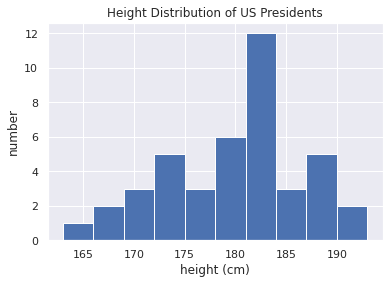

In [ ]:
plt.hist(heights)
plt.title('Height Distribution of US Presidents')
plt.xlabel('height (cm)')
plt.ylabel('number');

These aggregates are some of the fundamental pieces of exploratory data analysis that we'll explore in more depth in later chapters of the book.

# Computation on Arrays: Broadcasting

We saw in the previous section how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
Another means of vectorizing operations is to use NumPy's *broadcasting* functionality.
Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [ ]:
import numpy as np

In [ ]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes–for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [ ]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value ``5`` into the array ``[5, 5, 5]``, and adds the results.
The advantage of NumPy's broadcasting is that this duplication of values does not actually take place, but it is a useful mental model as we think about broadcasting.

We can similarly extend this to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [ ]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

Here the one-dimensional array ``a`` is stretched, or broadcast across the second dimension in order to match the shape of ``M``.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [ ]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [ ]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* ``a`` and ``b`` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure (Code to produce this plot can be found in the [appendix](06.00-Figure-Code.ipynb#Broadcasting), and is adapted from source published in the [astroML](http://astroml.org) documentation. Used by permission).

![Broadcasting Visual](figures/02.05-broadcasting.png)

The light boxes represent the broadcasted values: again, this extra memory is not actually allocated in the course of the operation, but it can be useful conceptually to imagine that it is.

## Rules of Broadcasting

Broadcasting in NumPy follows a strict set of rules to determine the interaction between the two arrays:

- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is *padded* with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

To make these rules clear, let's consider a few examples in detail.

### Broadcasting example 1

Let's look at adding a two-dimensional array to a one-dimensional array:

In [ ]:
M = np.ones((2, 3))
a = np.arange(3)

Let's consider an operation on these two arrays. The shape of the arrays are

- ``M.shape = (2, 3)``
- ``a.shape = (3,)``

We see by rule 1 that the array ``a`` has fewer dimensions, so we pad it on the left with ones:

- ``M.shape -> (2, 3)``
- ``a.shape -> (1, 3)``

By rule 2, we now see that the first dimension disagrees, so we stretch this dimension to match:

- ``M.shape -> (2, 3)``
- ``a.shape -> (2, 3)``

The shapes match, and we see that the final shape will be ``(2, 3)``:

In [ ]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.]])

### Broadcasting example 2

Let's take a look at an example where both arrays need to be broadcast:

In [ ]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

Again, we'll start by writing out the shape of the arrays:

- ``a.shape = (3, 1)``
- ``b.shape = (3,)``

Rule 1 says we must pad the shape of ``b`` with ones:

- ``a.shape -> (3, 1)``
- ``b.shape -> (1, 3)``

And rule 2 tells us that we upgrade each of these ones to match the corresponding size of the other array:

- ``a.shape -> (3, 3)``
- ``b.shape -> (3, 3)``

Because the result matches, these shapes are compatible. We can see this here:

In [ ]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

### Broadcasting example 3

Now let's take a look at an example in which the two arrays are not compatible:

In [ ]:
M = np.ones((3, 2))
a = np.arange(3)

This is just a slightly different situation than in the first example: the matrix ``M`` is transposed.
How does this affect the calculation? The shape of the arrays are

- ``M.shape = (3, 2)``
- ``a.shape = (3,)``

Again, rule 1 tells us that we must pad the shape of ``a`` with ones:

- ``M.shape -> (3, 2)``
- ``a.shape -> (1, 3)``

By rule 2, the first dimension of ``a`` is stretched to match that of ``M``:

- ``M.shape -> (3, 2)``
- ``a.shape -> (3, 3)``

Now we hit rule 3–the final shapes do not match, so these two arrays are incompatible, as we can observe by attempting this operation:

In [ ]:
M + a

ValueError: ignored

Note the potential confusion here: you could imagine making ``a`` and ``M`` compatible by, say, padding ``a``'s shape with ones on the right rather than the left.
But this is not how the broadcasting rules work!
That sort of flexibility might be useful in some cases, but it would lead to potential areas of ambiguity.
If right-side padding is what you'd like, you can do this explicitly by reshaping the array (we'll use the ``np.newaxis`` keyword introduced in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb)):

In [ ]:
a[:, np.newaxis].shape

(3, 1)

In [ ]:
M + a[:, np.newaxis]

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

Also note that while we've been focusing on the ``+`` operator here, these broadcasting rules apply to *any* binary ``ufunc``.
For example, here is the ``logaddexp(a, b)`` function, which computes ``log(exp(a) + exp(b))`` with more precision than the naive approach:

In [ ]:
np.logaddexp(M, a[:, np.newaxis])

array([[1.31326169, 1.31326169],
       [1.69314718, 1.69314718],
       [2.31326169, 2.31326169]])

For more information on the many available universal functions, refer to [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb).

## Broadcasting in Practice

Broadcasting operations form the core of many examples we'll see throughout this book.
We'll now take a look at a couple simple examples of where they can be useful.

### Centering an array

In the previous section, we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example is when centering an array of data.
Imagine you have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [ ]:
X = np.random.random((10, 3))

We can compute the mean of each feature using the ``mean`` aggregate across the first dimension:

In [ ]:
Xmean = X.mean(0)
Xmean

array([0.49831076, 0.50193438, 0.46752888])

And now we can center the ``X`` array by subtracting the mean (this is a broadcasting operation):

In [ ]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has near zero mean:

In [ ]:
X_centered.mean(0)

array([-4.44089210e-17,  3.33066907e-17, -9.43689571e-17])

To within machine precision, the mean is now zero.

### Plotting a two-dimensional function

One place that broadcasting is very useful is in displaying images based on two-dimensional functions.
If we want to define a function $z = f(x, y)$, broadcasting can be used to compute the function across the grid:

In [ ]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

We'll use Matplotlib to plot this two-dimensional array (these tools will be discussed in full in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)):

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

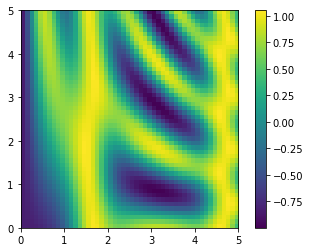

In [ ]:
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5],
           cmap='viridis')
plt.colorbar();

The result is a compelling visualization of the two-dimensional function.

# Comparisons, Masks, and Boolean Logic

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## Example: Counting Rainy Days

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [ ]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

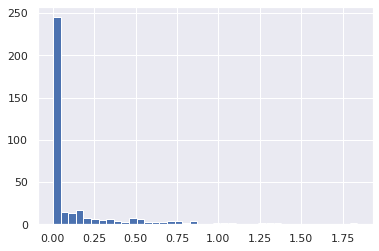

In [ ]:
plt.hist(inches, 40);

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

### Digging into the data

One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

## Comparison Operators as ufuncs

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [ ]:
x = np.array([1, 2, 3, 4, 5])

In [ ]:
x < 3  # less than

array([ True,  True, False, False, False])

In [ ]:
x > 3  # greater than

array([False, False, False,  True,  True])

In [ ]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False])

In [ ]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True])

In [ ]:
x != 3  # not equal

array([ True,  True, False,  True,  True])

In [ ]:
x == 3  # equal

array([False, False,  True, False, False])

It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

In [ ]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False])

As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

| Operator	    | Equivalent ufunc    || Operator	   | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

In [ ]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [ ]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]])

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## Working with Boolean Arrays

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [ ]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [ ]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [ ]:
np.sum(x < 6)

8

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [ ]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [ ]:
# are there any values greater than 8?
np.any(x > 8)

True

In [ ]:
# are there any values less than zero?
np.any(x < 0)

False

In [ ]:
# are all values less than 10?
np.all(x < 10)

True

In [ ]:
# are all values equal to 6?
np.all(x == 6)

False

``np.all`` and ``np.any`` can be used along particular axes as well. For example:

In [ ]:
# are all values in each row less than 8?
np.all(x < 8, axis=1)

array([ True, False,  True])

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

### Boolean operators

We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

For example, we can address this sort of compound question as follows:

In [ ]:
np.sum((inches > 0.5) & (inches < 1))

29

So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

``` python
inches > (0.5 & inches) < 1
```

Using the equivalence of *A AND B* and *NOT (NOT A OR NOT B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

In [ ]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

In [ ]:
print("Number days without rain:      ", np.sum(inches == 0))
print("Number days with rain:         ", np.sum(inches != 0))
print("Days with more than 0.5 inches:", np.sum(inches > 0.5))
print("Rainy days with < 0.2 inches  :", np.sum((inches > 0) &
                                                (inches < 0.2)))

Number days without rain:       215
Number days with rain:          150
Days with more than 0.5 inches: 37
Rainy days with < 0.2 inches  : 75


## Boolean Arrays as Masks

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [ ]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

We can obtain a Boolean array for this condition easily, as we've already seen:

In [ ]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]])

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [ ]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [ ]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.19488188976377951
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.8503937007874016
Median precip on non-summer rainy days (inches): 0.20078740157480315


By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

## Aside: Using the Keywords and/or Versus the Operators &/|

One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

In [ ]:
bool(42), bool(0)

(True, False)

In [ ]:
bool(42 and 0)

False

In [ ]:
bool(42 or 0)

True

When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

In [ ]:
bin(42)

'0b101010'

In [ ]:
bin(59)

'0b111011'

In [ ]:
bin(42 & 59)

'0b101010'

In [ ]:
bin(42 | 59)

'0b111011'

Notice that the corresponding bits of the binary representation are compared in order to yield the result.

When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

In [ ]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True])

Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

In [ ]:
A or B

ValueError: ignored

Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

In [ ]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False,
       False])

Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

In [ ]:
(x > 4) and (x < 8)

ValueError: ignored

So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

# Fancy Indexing

In the previous sections, we saw how to access and modify portions of arrays using simple indices (e.g., ``arr[0]``), slices (e.g., ``arr[:5]``), and Boolean masks (e.g., ``arr[arr > 0]``).
In this section, we'll look at another style of array indexing, known as *fancy indexing*.
Fancy indexing is like the simple indexing we've already seen, but we pass arrays of indices in place of single scalars.
This allows us to very quickly access and modify complicated subsets of an array's values.

## Exploring Fancy Indexing

Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once.
For example, consider the following array:

In [ ]:
import numpy as np
rand = np.random.RandomState(42)

x = rand.randint(100, size=10)
print(x)

[51 92 14 71 60 20 82 86 74 74]


Suppose we want to access three different elements. We could do it like this:

In [ ]:
[x[3], x[7], x[2]]

[71, 86, 14]

Alternatively, we can pass a single list or array of indices to obtain the same result:

In [ ]:
ind = [3, 7, 4]
x[ind]

array([71, 86, 60])

When using fancy indexing, the shape of the result reflects the shape of the *index arrays* rather than the shape of the *array being indexed*:

In [ ]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[71, 86],
       [60, 20]])

Fancy indexing also works in multiple dimensions. Consider the following array:

In [ ]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:

In [ ]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]

array([ 2,  5, 11])

Notice that the first value in the result is ``X[0, 2]``, the second is ``X[1, 1]``, and the third is ``X[2, 3]``.
The pairing of indices in fancy indexing follows all the broadcasting rules that were mentioned in [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb).
So, for example, if we combine a column vector and a row vector within the indices, we get a two-dimensional result:

In [ ]:
X[row[:, np.newaxis], col]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Here, each row value is matched with each column vector, exactly as we saw in broadcasting of arithmetic operations.
For example:

In [ ]:
row[:, np.newaxis] * col

array([[0, 0, 0],
       [2, 1, 3],
       [4, 2, 6]])

It is always important to remember with fancy indexing that the return value reflects the *broadcasted shape of the indices*, rather than the shape of the array being indexed.

## Combined Indexing

For even more powerful operations, fancy indexing can be combined with the other indexing schemes we've seen:

In [ ]:
print(X)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


We can combine fancy and simple indices:

In [ ]:
X[2, [2, 0, 1]]

array([10,  8,  9])

We can also combine fancy indexing with slicing:

In [ ]:
X[1:, [2, 0, 1]]

array([[ 6,  4,  5],
       [10,  8,  9]])

And we can combine fancy indexing with masking:

In [ ]:
mask = np.array([1, 0, 1, 0], dtype=bool)
X[row[:, np.newaxis], mask]

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

All of these indexing options combined lead to a very flexible set of operations for accessing and modifying array values.

## Example: Selecting Random Points

One common use of fancy indexing is the selection of subsets of rows from a matrix.
For example, we might have an $N$ by $D$ matrix representing $N$ points in $D$ dimensions, such as the following points drawn from a two-dimensional normal distribution:

In [ ]:
mean = [0, 0]
cov = [[1, 2],
       [2, 5]]
X = rand.multivariate_normal(mean, cov, 100)
X.shape

(100, 2)

Using the plotting tools we will discuss in [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb), we can visualize these points as a scatter-plot:

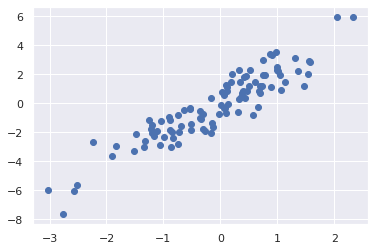

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling

plt.scatter(X[:, 0], X[:, 1]);

Let's use fancy indexing to select 20 random points. We'll do this by first choosing 20 random indices with no repeats, and use these indices to select a portion of the original array:

In [ ]:
indices = np.random.choice(X.shape[0], 20, replace=False)
indices

array([22, 34, 30, 40, 27, 12, 65,  5, 54, 74, 78, 96, 70, 18, 72, 89, 29,
       45, 36, 88])

In [ ]:
selection = X[indices]  # fancy indexing here
selection.shape

(20, 2)

Now to see which points were selected, let's over-plot large circles at the locations of the selected points:

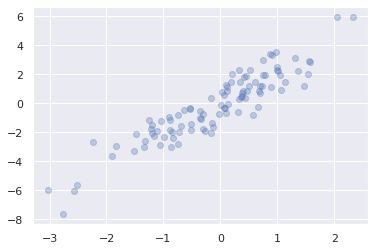

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(selection[:, 0], selection[:, 1],
            facecolor='none', s=200);

This sort of strategy is often used to quickly partition datasets, as is often needed in train/test splitting for validation of statistical models (see [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)), and in sampling approaches to answering statistical questions.

## Modifying Values with Fancy Indexing

Just as fancy indexing can be used to access parts of an array, it can also be used to modify parts of an array.
For example, imagine we have an array of indices and we'd like to set the corresponding items in an array to some value:

In [ ]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
print(x)

[ 0 99 99  3 99  5  6  7 99  9]


We can use any assignment-type operator for this. For example:

In [ ]:
x[i] -= 10
print(x)

[ 0 89 89  3 89  5  6  7 89  9]


Notice, though, that repeated indices with these operations can cause some potentially unexpected results. Consider the following:

In [ ]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Where did the 4 go? The result of this operation is to first assign ``x[0] = 4``, followed by ``x[0] = 6``.
The result, of course, is that ``x[0]`` contains the value 6.

Fair enough, but consider this operation:

In [ ]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

You might expect that ``x[3]`` would contain the value 2, and ``x[4]`` would contain the value 3, as this is how many times each index is repeated. Why is this not the case?
Conceptually, this is because ``x[i] += 1`` is meant as a shorthand of ``x[i] = x[i] + 1``. ``x[i] + 1`` is evaluated, and then the result is assigned to the indices in x.
With this in mind, it is not the augmentation that happens multiple times, but the assignment, which leads to the rather nonintuitive results.

So what if you want the other behavior where the operation is repeated? For this, you can use the ``at()`` method of ufuncs (available since NumPy 1.8), and do the following:

In [ ]:
x = np.zeros(10)
np.add.at(x, i, 1)
print(x)

[0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]


The ``at()`` method does an in-place application of the given operator at the specified indices (here, ``i``) with the specified value (here, 1).
Another method that is similar in spirit is the ``reduceat()`` method of ufuncs, which you can read about in the NumPy documentation.

## Example: Binning Data

You can use these ideas to efficiently bin data to create a histogram by hand.
For example, imagine we have 1,000 values and would like to quickly find where they fall within an array of bins.
We could compute it using ``ufunc.at`` like this:

In [ ]:
np.random.seed(42)
x = np.random.randn(100)

# compute a histogram by hand
bins = np.linspace(-5, 5, 20)
counts = np.zeros_like(bins)

# find the appropriate bin for each x
i = np.searchsorted(bins, x)

# add 1 to each of these bins
np.add.at(counts, i, 1)

The counts now reflect the number of points within each bin–in other words, a histogram:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  


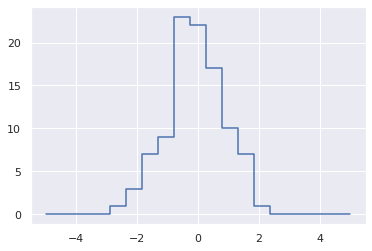

In [ ]:
# plot the results
plt.plot(bins, counts, linestyle='steps');

Of course, it would be silly to have to do this each time you want to plot a histogram.
This is why Matplotlib provides the ``plt.hist()`` routine, which does the same in a single line:

```python
plt.hist(x, bins, histtype='step');
```

This function will create a nearly identical plot to the one seen here.
To compute the binning, ``matplotlib`` uses the ``np.histogram`` function, which does a very similar computation to what we did before. Let's compare the two here:

In [ ]:
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
28.6 µs ± 870 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Custom routine:
15.1 µs ± 177 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Our own one-line algorithm is several times faster than the optimized algorithm in NumPy! How can this be?
If you dig into the ``np.histogram`` source code (you can do this in IPython by typing ``np.histogram??``), you'll see that it's quite a bit more involved than the simple search-and-count that we've done; this is because NumPy's algorithm is more flexible, and particularly is designed for better performance when the number of data points becomes large:

In [ ]:
x = np.random.randn(1000000)
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
87.6 ms ± 754 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Custom routine:
119 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


What this comparison shows is that algorithmic efficiency is almost never a simple question. An algorithm efficient for large datasets will not always be the best choice for small datasets, and vice versa (see [Big-O Notation](02.08-Sorting.ipynb#Aside:-Big-O-Notation)).
But the advantage of coding this algorithm yourself is that with an understanding of these basic methods, you could use these building blocks to extend this to do some very interesting custom behaviors.
The key to efficiently using Python in data-intensive applications is knowing about general convenience routines like ``np.histogram`` and when they're appropriate, but also knowing how to make use of lower-level functionality when you need more pointed behavior.

# Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This section covers algorithms related to sorting values in NumPy arrays.
These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about *insertion sorts*, *selection sorts*, *merge sorts*, *quick sorts*, *bubble sorts*, and many, many more.
All are means of accomplishing a similar task: sorting the values in a list or array.

For example, a simple *selection sort* repeatedly finds the minimum value from a list, and makes swaps until the list is sorted. We can code this in just a few lines of Python:

In [ ]:
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [ ]:
x = np.array([2, 1, 4, 3, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

As any first-year computer science major will tell you, the selection sort is useful for its simplicity, but is much too slow to be useful for larger arrays.
For a list of $N$ values, it requires $N$ loops, each of which does on order $\sim N$ comparisons to find the swap value.
In terms of the "big-O" notation often used to characterize these algorithms (see [Big-O Notation](#Aside:-Big-O-Notation)), selection sort averages $\mathcal{O}[N^2]$: if you double the number of items in the list, the execution time will go up by about a factor of four.

Even selection sort, though, is much better than my all-time favorite sorting algorithms, the *bogosort*:

In [ ]:
def bogosort(x):
    while np.any(x[:-1] > x[1:]):
        np.random.shuffle(x)
    return x

In [ ]:
x = np.array([2, 1, 4, 3, 5])
bogosort(x)

array([1, 2, 3, 4, 5])

This silly sorting method relies on pure chance: it repeatedly applies a random shuffling of the array until the result happens to be sorted.
With an average scaling of $\mathcal{O}[N \times N!]$, (that's *N* times *N* factorial) this should–quite obviously–never be used for any real computation.

Fortunately, Python contains built-in sorting algorithms that are *much* more efficient than either of the simplistic algorithms just shown. We'll start by looking at the Python built-ins, and then take a look at the routines included in NumPy and optimized for NumPy arrays.

## Fast Sorting in NumPy: ``np.sort`` and ``np.argsort``

Although Python has built-in ``sort`` and ``sorted`` functions to work with lists, we won't discuss them here because NumPy's ``np.sort`` function turns out to be much more efficient and useful for our purposes.
By default ``np.sort`` uses an $\mathcal{O}[N\log N]$, *quicksort* algorithm, though *mergesort* and *heapsort* are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array without modifying the input, you can use ``np.sort``:

In [ ]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

If you prefer to sort the array in-place, you can instead use the ``sort`` method of arrays:

In [ ]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is ``argsort``, which instead returns the *indices* of the sorted elements:

In [ ]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [ ]:
x[i]

array([1, 2, 3, 4, 5])

### Sorting along rows or columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the ``axis`` argument. For example:

In [ ]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [ ]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [ ]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy provides this in the ``np.partition`` function. ``np.partition`` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [ ]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [ ]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a ``np.argsort`` that computes indices of the sort, there is a ``np.argpartition`` that computes indices of the partition.
We'll see this in action in the following section.

## Example: k-Nearest Neighbors

Let's quickly see how we might use this ``argsort`` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [ ]:
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

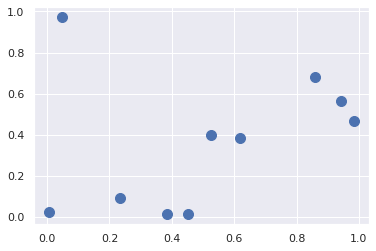

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points.
Recall that the squared-distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [ ]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [ ]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [ ]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [ ]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [ ]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It checks out!
With the pairwise square-distances converted, we can now use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [ ]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 3 9 7 1 4 2 5 6 8]
 [1 4 7 9 3 6 8 5 0 2]
 [2 1 4 6 3 0 8 9 7 5]
 [3 9 7 0 1 4 5 8 6 2]
 [4 1 8 5 6 7 9 3 0 2]
 [5 8 6 4 1 7 9 3 2 0]
 [6 8 5 4 1 7 9 3 2 0]
 [7 9 3 1 4 0 5 8 6 2]
 [8 5 6 4 1 7 9 3 2 0]
 [9 7 3 0 1 4 5 8 6 2]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the ``np.argpartition`` function:

In [ ]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors:

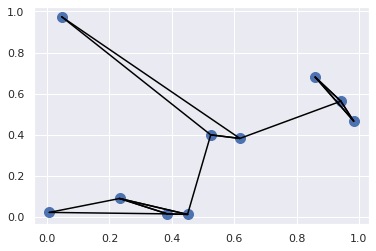

In [ ]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

Although the broadcasting and row-wise sorting of this approach might seem less straightforward than writing a loop, it turns out to be a very efficient way of operating on this data in Python.
You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually, but this would almost certainly lead to a slower algorithm than the vectorized version we used. The beauty of this approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.

Finally, I'll note that when doing very large nearest neighbor searches, there are tree-based and/or approximate algorithms that can scale as $\mathcal{O}[N\log N]$ or better rather than the $\mathcal{O}[N^2]$ of the brute-force algorithm. One example of this is the KD-Tree, [implemented in Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html).

## Aside: Big-O Notation

Big-O notation is a means of describing how the number of operations required for an algorithm scales as the input grows in size.
To use it correctly is to dive deeply into the realm of computer science theory, and to carefully distinguish it from the related small-o notation, big-$\theta$ notation, big-$\Omega$ notation, and probably many mutant hybrids thereof.
While these distinctions add precision to statements about algorithmic scaling, outside computer science theory exams and the remarks of pedantic blog commenters, you'll rarely see such distinctions made in practice.
Far more common in the data science world is a less rigid use of big-O notation: as a general (if imprecise) description of the scaling of an algorithm.
With apologies to theorists and pedants, this is the interpretation we'll use throughout this book.

Big-O notation, in this loose sense, tells you how much time your algorithm will take as you increase the amount of data.
If you have an $\mathcal{O}[N]$ (read "order $N$") algorithm that takes 1 second to operate on a list of length *N*=1,000, then you should expect it to take roughly 5 seconds for a list of length *N*=5,000.
If you have an $\mathcal{O}[N^2]$ (read "order *N* squared") algorithm that takes 1 second for *N*=1000, then you should expect it to take about 25 seconds for *N*=5000.

For our purposes, the *N* will usually indicate some aspect of the size of the dataset (the number of points, the number of dimensions, etc.). When trying to analyze billions or trillions of samples, the difference between $\mathcal{O}[N]$ and $\mathcal{O}[N^2]$ can be far from trivial!

Notice that the big-O notation by itself tells you nothing about the actual wall-clock time of a computation, but only about its scaling as you change *N*.
Generally, for example, an $\mathcal{O}[N]$ algorithm is considered to have better scaling than an $\mathcal{O}[N^2]$ algorithm, and for good reason. But for small datasets in particular, the algorithm with better scaling might not be faster.
For example, in a given problem an $\mathcal{O}[N^2]$ algorithm might take 0.01 seconds, while a "better" $\mathcal{O}[N]$ algorithm might take 1 second.
Scale up *N* by a factor of 1,000, though, and the $\mathcal{O}[N]$ algorithm will win out.

Even this loose version of Big-O notation can be very useful when comparing the performance of algorithms, and we'll use this notation throughout the book when talking about how algorithms scale.